# Определение стоимости автомобилей

## Резюме исследования

**Заголовок:** Исследование характеристик автомобиля для прогнозирования их стоимости

**Описание проекта:** Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. В распоряжении есть данные о технических характеристиках, комплектации и ценах других автомобилей.

**Критерии, которые важны заказчику:**
1. Качество предсказания.
2. Время обучения модели.
3. Время предсказания модели.

**Цель исследования:** 
1. Спрогнозировать рыночную стоимость автомобиля.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, преобразование аномальных значений, корректировка типов данных
* Исследовательский анализ данных: анализ количественных и категориальных признаков, корреляционный анализ признаков
* Формирование пайплайна и обучение моделей регрессии (таргет - цена автомобиля), оценка их качества

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов

## Импорт библиотек

In [1]:
!pip install phik -q
!pip install shap -q
!pip install numpy==1.22.4 -q
!pip install matplotlib==3.5.3 -q

In [2]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import phik
import time
import shap
import lightgbm as lgb
import sklearn

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.utils.fixes")

# загружаем библиотеки для проверки признаков на мультиколлениарность
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold

from sklearn.inspection import permutation_importance

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

# загружаем функцию для копирования параметров модели без обученных весов
from sklearn.base import clone

# Загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, accuracy_score, confusion_matrix

from sklearn.dummy import DummyRegressor

from typing import Union, List, Dict

from numpy.random import RandomState

# Импорт метода для проверки нормальности распределения
from scipy.stats import shapiro, mannwhitneyu, normaltest

from scipy import stats as st

# Задаём настройки для разделения выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 8);

# Настройка отображения
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)        # Ширина отображения
pd.set_option('display.max_colwidth', None)   # Максимальная ширина столбца
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


## Классы и функции

### Классы для обработки датасета

In [3]:
# Создадим классы для работы с датасетами и колонками

# Класс (датафрейм)
class Data:
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Данные должны быть типа pd.DataFrame')
        
        self.data = data
        self.X_train = None
        self.X_test_transformed = None
        self.y_train = None
        self.y_test = None
        
        self.selected_features = list(self.data.columns)
        
    def show_info(self): # Функция для анализа общей информации по датасету
        self.data.info()

    def print_head(self, n: int = 5): # Функция для ознакомления с данными
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Параметр n должен быть положительным целым числом больше нуля')
        return self.data.head(n)

    def unify_columns(self, df: pd.DataFrame): # Функция для перевода имён столбцов по словарю
        new_cols = {}
        for eng_key, ru_names in dict_column_translations.items():
            for ru_name in ru_names:
                if ru_name in df.columns:
                    new_cols[ru_name] = eng_key
                    break
        df.rename(columns=new_cols, inplace=True)
    
    def get_numeric_columns(self) -> list: # Функция для получения списка столбцов с числовыми данными
        return self.data.select_dtypes(include=['number']).columns.tolist()
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Функция для ознакомления с количественными показателями
        numeric_columns = self.get_numeric_columns()
        return self.data[numeric_columns].describe(percentiles=percentiles)
    
    def count_duplicates(self): # Функция для подсчета явных дубликатов
        return self.data.duplicated().sum()
    
    def get_duplicate_rows(self): # Функция для вывода явных дубликатов
        return self.data[self.data.duplicated(keep=False)]
    
    def get_string_columns(self): # Возвращает список строковых столбцов
        string_columns = self.data.select_dtypes(include=['object', 'string', 'category']).columns
        if string_columns.empty:
            print('Строковых и категориальных столбцов нет')
            return []
        else:
            return string_columns
    
    def show_unique_vals_str_cat_columns(self, column_name: Union[str, list[str], None] = None): # Выводит уникальные значения в строковых столбцах
        max_display = 30
        if column_name is None:
            columns = self.get_string_columns()
        elif isinstance(column_name, str):
            columns = [column_name]
        else:
            columns = column_name
            
        for col in columns:
            unique_values = sorted(self.data[col].dropna().unique())
            print(f'Уникальные значения для столбца: {col}')
            print(f'Количество уникальных значений: {len(unique_values)}')
            if len(unique_values) <= max_display:
                print(unique_values)
                print('-' * 30)
            else:
                print(unique_values[:max_display])
                print('-' * 30)
                
    def drop_duplicate_rows(self): # Функция для удаления явных дубликатов
        self.data.drop_duplicates(keep='first', inplace=True)
        return self.data

    def count_missing_values(self): # Функция для подсчета строк с пропущенными значениями
        return self.data.isna().sum()

    def fill_na_categorical(self):
        """
        Заполняет пропуски в категориальных столбцах значением 'unknown'.
        Работает и для object, и для category.
        """
        # Определяем категориальные столбцы
        cat_columns = [
            col for col in self.data.columns
            if self.data[col].dtype == object or pd.api.types.is_categorical_dtype(self.data[col])
        ]
        
        for col in cat_columns:
            col_obj = Column(self.data, col)
            
            # Если колонка Categorical, добавляем новую категорию
            if pd.api.types.is_categorical_dtype(col_obj.get_type()):
                col_obj.data[col].cat.add_categories(['unknown'], inplace=True)
            
            col_obj.fill_na('unknown')
        
        print(f'Пропуски в {len(cat_columns)} категориальных столбцах заменены на "unknown".')


    
    def drop_na(self, column_name: str): # Функция для удаления строк с пропущенными значениями
        self.data.dropna(subset=[column_name], inplace=True)
        return self.data
    
    def count_rows(self): # Функция для подсчета строк
        return len(self.data)
    
    def to_lowercase_columns(self): # Фунция для приведения имен столбцов в нижний регистр
        self.data.columns = self.data.columns.str.lower()
        print(self.data.columns)
    
    def replace_multiple_column_name(self, replacements: dict): # Функция для множественной замены символов в названиях столбцов
        def replace_chars(value):
            for old, new in replacements.items():
                value = value.replace(old, new)
            return value
        
        self.data.columns = self.data.columns.map(replace_chars)
        print(self.data.columns)
        
    def process_string_columns(self, columns, replacements=dict, lowercase_list=None):
        for col in columns:
            col_obj = Column(self.data, col)
            
            if lowercase_list and col in lowercase_list:
                col_obj.to_lowercase_rows()
                
            if replacements:
                col_obj.replace_strings(replacements)
                
            self.show_unique_vals_string_columns(column_name=col)
    
    def convert_columns_to_float(self, column_names: list[str], replacements: Union[Dict, None] = None): # Функция для замены типа данных на 'float'
        for col in column_names:
            if col in self.data.columns:
                col_obj = Column(self.data, col)
                if replacements:
                    col_obj.replace_strings(replacements)
                col_obj.change_type('float')
                print(f'Тип данных для столбца {col} изменен на {col_obj.get_type()}')
                
    def modify_data(self, index: str, columns: str, values: str, column_rename: Dict, column_order: List):
        '''Функция для трансформации датасета с выделением периодов в отдельные столбцы'''
        transformed_data = (self.data.pivot(index=index, columns=columns, values=values)\
              .reset_index()\
              .rename(columns=column_rename)\
              .rename_axis(None, axis=1)
             )\
        .copy()

        # Определяем желаемый порядок столбцов
        transformed_data = transformed_data[column_order]

        # Создаем новый экземпляр класса Data()
        new_data = Data(transformed_data)
        
        # Можно сохранить оригинальное имя с суффиксом
        new_data.name = f'{self.name}' if hasattr(self, 'name') else 'modified_dataset'

        # Возвращаем результат
        return new_data

    
    # Подготовка данных для тестирование модели, оценка качества модели
    
    def split(self, target_column: str, random_state=42, stratify=None): # Функция для разделения выборки на тренировочную и тестовую
        if target_column not in self.data.columns:
            raise ValueError(f"Целевая колонка '{target_column}' отсутствует в данных")
        
        X = self.data.drop(columns=target_column)
        y = self.data[target_column]
        
        stratify_param = y if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, random_state=random_state, stratify=stratify_param
        )
        
        print(f'Разделение завершено: обучающая выборка - {self.X_train.shape}, тестовая - {self.X_test.shape}')

        
    def select_features(self, features: list[str]): # Функция для отбора фичей
        # Проверяем, все ли запрошенные признаки есть в исходных данных
        missing = [f for f in features if f not in self.data.columns]
        if missing:
              raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        # Отбираем только нужные признаки
        self.selected_features = features
        print(f'Выбраны следующие признаки: {features}')
        
    def reset_features(self):
        self.selected_features = list(self.data.columns)
        print('Сброшен выбор признаков — используются все признаки.')
        
    def count_linear_regression_metrics(self, y_true_list: list, y_pred_list: list, model_names: list[str]) -> pd.DataFrame: # Функция для подсчета метрик линейной регресии
        if not (len(y_true_list) == len(y_pred_list) == len(model_names)):
            raise ValueError('Все входные списки должны быть одинаковой длины.')

        results = []

        for y_true, y_pred, name in zip(y_true_list, y_pred_list, model_names):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            results.append({
                'Model': name,
                'MSE': round(mse, 2),
                'RMSE': round(rmse, 2),
                'MAE': round(mae, 2),
                'R2': round(r2, 2)
            })

        return pd.DataFrame(results)

    
    def count_logistic_regression_metrics(self, y_true: np.array, y_pred: np.array): # Функция для подсчета метрик логистической регресии
    
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    
        results = {
            'accuracy': round(accuracy, 2),
            'recall': round(recall, 2),
            'precision': round(precision, 2)
        }

        return pd.DataFrame([results])


    def threshold_table(self, y_true: np.array, y_proba): # Функция для вывода таблицы метрик Precision, Recall при разных порогах
        
        thresholds = np.arange(0.0, 1.0, 0.02)  # от 0 до 1 с шагом 0.02
        rows = []
    
        total_class_1 = (y_true == 1).sum()  # сколько всего объектов класса 1
    
        for thr in thresholds:
            y_pred = (y_proba >= thr).astype(int)  # применяем порог
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            predicted_count = y_pred.sum()
            accuracy = accuracy_score(y_true, y_pred)

            # Считаем False Positive и False Negative
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()
    
            rows.append({
                'Порог': round(thr, 2),
                'Recall': round(recall, 3),
                'Precision': round(precision, 3),
                'Accuracy':accuracy,
                'Количество False Positive':fp,
                'Количество False Negative':fn,
                'Число предсказанных объектов': predicted_count,
                'Всего объектов класса 1': total_class_1
            })

        return pd.DataFrame(rows)

### Классы для обработки столбцов

In [4]:
# Класс (столбец датафрейма)
class Column():
    def __init__(self, data: pd.DataFrame, column_name: str):
        self.data = data
        self.column_name = column_name
        self.series = data[column_name]
        
        if column_name not in self.data.columns:
            raise KeyError(f'Столбец "{column_name}" не найден в датафрейме')
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Функция для ознакомления с количественными показателями
        return self.series.describe(percentiles=percentiles)
    
    def count_values(self): # Функция для вывода и подсчета уникальных значений
        return self.series.value_counts()
    
    def fill_na(self, new_value): # Функция для заполнения пропущенных значений
        self.data[self.column_name].fillna(new_value, inplace=True)
        self.series = self.data[self.column_name]
        return self.series
    
    def replace_strings(self, replacements):
        for old, new in replacements.items():
            self.data[self.column_name] = self.data[self.column_name].str.replace(old, new, regex=False)
            self.series = self.data[self.column_name]
        return self.series
    
    def change_type(self, new_type): # Функция для изменения типов данных
        self.data[self.column_name] = self.data[self.column_name].astype(new_type)
        self.series = self.data[self.column_name]
        return self.series
    
    def get_type(self): # Функция для выводы типа данных
        return self.series.dtype
    
    def to_lowercase_rows(self): # Фунция для приведения значений в нижний регистр
        self.data[self.column_name] = self.data[self.column_name].str.lower()
        self.series = self.data[self.column_name]
        return self.series
    
    def print_unique(self): # Функция для отображения уникальных значений в колонке
        return self.series.unique()

### Классы для обработки групп датасетов

In [5]:
# Создадим класс для работы с группой датасетов

class DatasetManager:
    def __init__(self, datasets: dict[str, Data]):
        self.datasets = datasets
        
    def show_info_all(self): # Выводит общую информацию о каждом датасете
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.show_info()
            print('-' * 30)
            print()
            
    def print_head_all(self, n = 5): # Выводит заданное количество строк в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.print_head(n))
            print('-' * 30)
            
    def describe_numeric_all(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Выводит описательную статистику в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.describe_numeric(percentiles=percentiles))
            print('-' * 30)

    def to_lowercase_columns_all(self): # Приводит имена столбцов к виду snake_case в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.to_lowercase_columns()
            print('-' * 30)
            
    def replace_multiple_column_name_all(self, replacements): # Проводит замену символов в именах столбцов с использованием словаря
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.replace_multiple_column_name(replacements)
            print('-' * 30)
            
    def get_duplicate_rows_all(self): # Показывает явные дубликаты в столбцах датасетов
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.get_duplicate_rows()
            print('-' * 30)

    def drop_duplicate_rows_all(self, exclude: Union[list[str], None] = None):
        exclude = exclude or []  # если None, то делаем пустой список
        
        for name, df in self.datasets.items():
            if name in exclude:
                print(f'Пропущен датасет: {name}')
                print('-' * 30)
                continue
            
            print(f'Имя датасета: {name}')
            print(f'Количество строк всего: {df.count_rows()}')
            print(f'Количество дубликатов в {name}: {df.count_duplicates()}')
            df.drop_duplicate_rows()
            print(f'Количество строк после удаления дубликатов: {df.count_rows()}')
            print('-' * 30)
            
    def show_unique_vals_string_columns_all(self): # Выводит уникальные значения в столбцах с строковым типом данных в разрезе датасета
        for name, df in self.datasets.items():
            print(f'Имя датасета: {name}')
            print()
            df.show_unique_vals_string_columns()
            print()
            print('/-' * 30)
            print()

### Классы для построения графиков

In [6]:
# Создадим класс для визуализаций

class Visualizer:
    def __init__(self, data: pd.DataFrame, translations: dict = None):
        self.translations = translations or {}
        self.data = data.rename(columns=self.translations)
        
    def boxplot(self, y: Union[str, list[str]], x: str = None, hue: str = None): # Функция для построения ящика с усами
        # Приводим y к списку
        y_list = [y] if isinstance(y, str) else y
        
        columns_to_check = y_list.copy()
        
        if hue:
            columns_to_check.append(hue)
        elif x:
            columns_to_check.append(x)

        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')

        df = self.data

        # Создание сабплотов
        n = len(y_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, y_label in enumerate(y_list):
            ax = axes[i]

            sns.boxplot(
                data=df,
                x=x,
                y=y_label,
                hue=hue,
                ax=ax
            )

            
            title = f'Диаграмма размаха: {y_label}'
            if x:
                title += f', срез: {x}'
            elif hue:
                title += f' и {hue}'
            ax.set_title(title)

        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
        
    def barplot(self, x: Union[str, list[str]], hue: str = None): # Функция для построения столбчатой диаграммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list.copy()
        
        if hue:
            columns_to_check.append(hue)
            
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
            
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Функция для добавления подписей с увеличенными границами
        def add_value_labels(ax):
            # Получаем текущие пределы оси X
            xmin, xmax = ax.get_xlim()
            # Увеличиваем пределы на 20% (можно настроить под свои нужды)
            ax.set_xlim(xmin, xmax * 1.2)  # Увеличиваем только правую границу

            for p in ax.patches:
                width = p.get_width()
                ax.annotate(
                    f'{int(width)}', 
                    xy=(width, p.get_y() + p.get_height() / 2),
                    xytext=(5, 0),  # Отступ от столбца
                    textcoords='offset points',
                    ha='left', 
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.5, boxstyle="round,pad=0.2")
                )

        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
                    
            # Подсчет частот
            if hue:
                df_count = (df.groupby([x_label, hue]).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
            else:
                df_count = (df.groupby(x_label).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
                
            # Преобразуем категории в строки, если они числовые
            df_count[x_label] = df_count[x_label].astype(str)
               
            # Создаем горизонтальный барплот
            if hue:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    hue=hue,
                    ax=ax
                )
               
            else:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    color='blue',
                    ax=ax
                )
                
            # Добавляем подписи с увеличенными границами
            add_value_labels(ax)

            
            # Заголовок и подписи осей
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')

            # Настройка отображения
            ax.tick_params(axis='x', labelrotation=0)
            ax.tick_params(axis='y', labelrotation=0)
                
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        ax.margins(x=0.1)  # Добавляем отступы
        plt.tight_layout(rect=[0, 0, 1, 1], pad=3)
        plt.show()
         
        
    def histplot(self, x: Union[str, list[str]], measurement: Union[str, list[str]] , hue: str = None, **kwargs): # Функция для построения гистограммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        measurement_list = [measurement] if isinstance(measurement, str) else measurement

        # Проверка согласованности размеров
        if len(x_list) != len(measurement_list):
            raise ValueError('Длины x_list и measurement_list должны совпадать')
        
        columns_to_check = x_list.copy() # Формируем список столбцов для проверки
        
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data

        # Достаём stat из kwargs (если не передан — берём 'count')
        stat = kwargs.get('stat', 'count')
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        if n == 1:
            fig, axes = plt.subplots(figsize=(8, 6))
            axes = [axes]
        else:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
            axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, (x_label, measurement_label) in enumerate(zip(x_list, measurement_list)):

            # Определяем количество бинов
            if pd.api.types.is_numeric_dtype(df[x_label]):
                bins = min(max(30, df[x_label].nunique() * 2), 100)  # максимум 100 столбцов
            else:
                bins = df[x_label].nunique()

            ax = axes[i]
            
            sns.histplot(
                data=df,
                x=x_label,
                hue=hue,
                kde=True, # Показать плотность распределения
                element='poly',
                ax=ax,
                bins=bins,
                **kwargs
            )
                        
            # Добавляем подписи осей
            ax.set_xlabel(f'{x_label}, {measurement_label}')
            if stat == 'density':
                ax.set_ylabel(f'distribution density')
            else:
                ax.set_ylabel(f'Количество')
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')
            
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
        
        
    def scatterplot(self, x: Union[str, list[str]], y: str, hue: str = None): # Функция для построения диаграммы рассеяния
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x

        # Формируем список столбцов для проверки
        columns_to_check = x_list.copy() + [y]

        # Если есть параметр hue
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            # Добавляем диаграмму рассеивания
            sns.scatterplot(
                data=df,
                x=x_label,
                y=y,
                hue=hue,
                alpha=0.7,
                palette='Set2',
                ax=ax
            )
            
            # Добавляем линию регрессии по каждой категории
            if hue:
                for category in df[hue].unique():
                    subset = df[df[hue] == category]
                    sns.regplot(
                        data=subset,
                        x=x_label,
                        y=y,
                        scatter=False,
                        ax=ax,
                        label=category
                    )

                ax.set_title(f'Зависимость {y} от {x_label}')
                ax.legend().set_title(hue)
                
            else:
                sns.regplot(
                    data=df,
                    x=x_label,
                    y=y,
                    scatter=False,
                    ax=ax
                )

                ax.set_title(f'Зависимость {y} от {x_label}')
            
        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

## Первичный анализ датасета

### Загрузка данных

In [7]:
# Загрузим датафрейм
df_auto = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [8]:
# Инициализируем датафрейм
df_auto = Data(df_auto)

### Знакомство с данными

In [9]:
# Ознакомимся с данными
df_auto.print_head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Видим значения NaN в столбцах `VehicleType`, `Model`, `Repaired	`

### Анализ общей информации

In [10]:
# Проанализируем общую информацию
df_auto.show_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Промежуточные выводы

* **Количество строк:** 354 369  

* **Пропущенные значения:** присутствуют в следующих столбцах:  
  - *VehicleType* 
  - *Gearbox*
  - *Model*
  - *FuelType*
  - *Repaired*

* **Необходимые преобразования:**  
  - Преобразовать даты (*DateCrawled*, *DateCreated*, *LastSeen*) в формат `datetime` для корректной работы с временными данными (например, сортировка, фильтрация, извлечение даты и времени).  
  - Проверить диапазон значений в числовых признаках (*Price*, *RegistrationYear*, *Power*) — возможны некорректные или экстремальные значения.  
  - Обработать пропуски в категориальных признаках — заменить на наиболее частое значение, категорию `"unknown"` или удалить строки при необходимости.  


* **Типы данных:**  
  - **Числовые:** *Price*, *RegistrationYear*, *Power*, *Kilometer*, *RegistrationMonth*, *NumberOfPictures*, *PostalCode* — корректно заданы как `int64`.  
  - **Временные:** *DateCrawled*, *DateCreated*, *LastSeen* — имеют тип `object`, необходимо привести к типу `datetime64[ns]` для удобства анализа по датам (например, изучения динамики размещения объявлений или активности пользователей).  
  - **Категориальные:** *VehicleType*, *Gearbox*, *Model*, *FuelType*, *Brand*, *Repaired* — представлены как `object`, рекомендуется преобразовать их в категориальный тип `category` для оптимизации памяти и повышения скорости обработки данных.



## Подготовка данных

### Преобразование типов данных в столбцах

In [11]:
# Создаем список из наименований столбцов с временнЫм типом данных
type_change_columns = {'datetime64[ns]': ['DateCrawled', 'DateCreated', 'LastSeen'],
                       'category': ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']}

# Преобразуем тип данных в цикле
for dtype, columns in type_change_columns.items():
    for col in columns:
        column_object = Column(df_auto.data, col)
        column_object.change_type(dtype)

# Смотрим на результат
df_auto.show_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  category      
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  category      
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  category      
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  category      
 10  Brand              354369 non-null  category      
 11  Repaired           283215 non-null  category      
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Типы данных приведение в соответствие

Проанализируем период создания анкеты

In [12]:
# Новая колонка для группировки объявлений
df_auto.data['YearMonthCreated'] = df_auto.data['DateCreated'].dt.to_period('D')

# Сгруппируем данные по дате и посмотрим на количество объявлений
(df_auto.data.groupby('YearMonthCreated')\
    .size()\
    .reset_index(name='count'))

,YearMonthCreated,count
0,2014-03-10,1
1,2015-03-20,1
2,2015-06-18,1
3,2015-08-07,1
4,2015-08-10,1
...,...,...
104,2016-04-03,13719
105,2016-04-04,13317
106,2016-04-05,4104
107,2016-04-06,1105


Абсолютно большинство объявлений было опубликовано в марте-апреле 2016 года

### Преобразование пропущенных значений

In [13]:
# Выведем количество незаполненных значений
df_auto.data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
YearMonthCreated         0
dtype: int64

In [14]:
# Посмотрим на распределение пропусков по бренду и модели
df_auto.data.groupby(['Brand', 'Model'])[['VehicleType']].apply(lambda x: x.isna().sum()).reset_index().sort_values(by='VehicleType', ascending=False)

,Brand,Model,VehicleType
9616,volkswagen,golf,4035.00
9673,volkswagen,polo,1600.00
6083,opel,corsa,1576.00
511,bmw,3er,1312.00
6042,opel,astra,1187.00
...,...,...,...
9995,volvo,yaris,NaN
9996,volvo,yeti,NaN
9997,volvo,ypsilon,NaN
9998,volvo,z_reihe,NaN


Однозначно заполнить такие пропуски невозможно, поэтому заполним их категорией "unknown" на этапе построения пайплайна моделей

### Обработка явных дубликатов

In [15]:
# Посмотрим на явные дубликаты в датасете
df_auto.get_duplicate_rows()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearMonthCreated
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15,2016-03-18
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57,2016-03-08
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21,2016-03-28
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57,2016-03-08
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54,2016-04-03
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21,2016-03-28
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54,2016-04-03
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15,2016-03-18


In [16]:
# Посчитаем их количество
len(df_auto.get_duplicate_rows())

8

Обнаружены явные дубликаты, очистим датасет от таких дубликатов

In [17]:
# Удалим дубликаты
df_auto.drop_duplicate_rows()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,YearMonthCreated
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,2016-03-24
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2016-03-24
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,2016-03-14
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2016-03-17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2016-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49,2016-03-21
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52,2016-03-14
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,2016-03-05
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,2016-03-19


In [18]:
# Снова посчитаем количество дубликатов
len(df_auto.get_duplicate_rows())

0

Датасет очищен от явных дубликатов

### Обработка неявных дубликатов

In [19]:
# Выводим уникальные значения в столбцах с строковым типом данных
df_auto.show_unique_vals_str_cat_columns()

Уникальные значения для столбца: VehicleType
Количество уникальных значений: 8
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
------------------------------
Уникальные значения для столбца: Gearbox
Количество уникальных значений: 2
['auto', 'manual']
------------------------------
Уникальные значения для столбца: Model
Количество уникальных значений: 250
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4']
------------------------------
Уникальные значения для столбца: FuelType
Количество уникальных значений: 7
['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']
------------------------------
Уникальные значения для столбца: Brand
Количество уникальных значений: 40
['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat',

Неявные дубликаты не обнаружены

### Промежуточные выводы

* Типы данных в столбцах с временнЫми и категориальными данными приведены в соответствие
* Пропущенные значения в 6-ти категориальных столбцах заполнены заглушкой "unknown" на этапе построения пайплайна моделей
* Удалено 8 явных дубликатов
* Неявные дубликаты не обнаружены

## Исследовательский анализ данных

### Описательная статистика

In [20]:
# Посмотрим на параметры столбцов с числовыми значениями
df_auto.describe_numeric()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.00,354365.00,354365.00,354365.00,354365.00,354365.00,354365.00
mean,4416.68,2004.23,110.09,128211.36,5.71,0.00,50508.50
std,4514.18,90.23,189.85,37905.08,3.73,0.00,25783.10
min,0.00,1000.00,0.00,5000.00,0.00,0.00,1067.00
25%,1050.00,1999.00,69.00,125000.00,3.00,0.00,30165.00
50%,2700.00,2003.00,105.00,150000.00,6.00,0.00,49413.00
75%,6400.00,2008.00,143.00,150000.00,9.00,0.00,71083.00
95%,14600.00,2016.00,218.00,150000.00,12.00,0.00,93109.00
99%,18800.00,2018.00,300.00,150000.00,12.00,0.00,98596.00
99.5%,19500.00,2018.00,334.00,150000.00,12.00,0.00,99510.00


В столбцах `RegistrationYear`, `Power` есть аномально высокие значения, а также нули в столбцах `Price`, `Power`, посмотрим на них

#### Преобразование аномально высоких значений

In [21]:
# Посмотрим на аномалии в столбце
len(df_auto.data.loc[df_auto.data['RegistrationYear'] == 9999])

26

Здесь скорее всего это заглушка, определена владельцем датасета для автомобилей без указанного года регистрации

In [22]:
# Новая колонка для группировки объявлений
df_auto.data['YearMonthCrawled'] = df_auto.data['DateCrawled'].dt.to_period('M')

# Сгруппируем данные по дате скачивания объявлений
(df_auto.data.groupby('YearMonthCrawled')\
    .size()\
    .reset_index(name='count'))

,YearMonthCrawled,count
0,2016-03,296821
1,2016-04,57544


На заключительном этапе фильтрации датасета исключим позиции с некорректным годом регистрации

Скорректируем аномальные значения мощности двигателя более 1000 л.с.

In [23]:
# Словарь условий и делителей
power_corrections = {
    10000: 100,  # если >=10000, делим на 100
    1000: 10     # если >=1000, делим на 10
}

# Применяем по порядку (от большего к меньшему, чтобы не перезаписать)
for threshold, divisor in sorted(power_corrections.items(), reverse=True):
    mask = df_auto.data['Power'] >= threshold
    df_auto.data.loc[mask, 'Power'] = df_auto.data.loc[mask, 'Power'] / divisor

In [24]:
# Фильтруем машины с Power > 400
high_power = df_auto.data[df_auto.data['Power'] > 400]

# Группируем по Brand и Model и считаем количество
grouped = high_power.groupby(['Brand']).size().reset_index(name='count')

# Сортируем по количеству (по желанию)
grouped = grouped.sort_values(by='count', ascending=False).query('count > 0')

# Выводим результат
display(grouped)

,Brand,count
1,audi,120
20,mercedes_benz,79
38,volkswagen,60
26,porsche,45
2,bmw,43
24,opel,20
10,ford,12
3,chevrolet,11
33,sonstige_autos,10
27,renault,10


За исключением Porsche, мощность более 400 л.с. маловероятна у автомобилей представленных брендов. Удалим строки с такими аномально высокими значениями мощности

#### Преобразование аномально низких значений

Выше мы наблюдали аномально низкие значения у признаков `Price` и `Power`

In [25]:
# Посмотрим, сколько строк с нулевой ценой автомобиля
round(len(df_auto.data.loc[df_auto.data['Price'] == 0]) / len(df_auto.data) * 100, 1)

3.0

Можем отфильтровать датасет от строк с нулевой стоимостью

In [26]:
# Посмотрим, сколько строк с нулевой мощностью двигателя
round(len(df_auto.data.loc[df_auto.data['Power'] == 0]) / len(df_auto.data) * 100, 1)

11.4

In [27]:
# Посмотрим, сколько строк с низкой ценой авто
round(len(df_auto.data.loc[df_auto.data['Price'] < 500]) / len(df_auto.data) * 100, 1)

10.2

Значимая часть датасета заполнена некорректной мощностью. Заменим такие значения медианой по марке, модели и году регистрации

In [28]:
# --- Функция для замены аномалий на медиану группы ---
def replace_with_group_median(df, column, group_cols, condition):
    median = df.groupby(group_cols)[column].transform('median')
    df.loc[condition & median.notna(), column] = median[condition & median.notna()]
    return df

# --- Обработка цен и мощности ---
df = df_auto.data

df = replace_with_group_median(df, 'Price',
                               ['Brand', 'Model', 'RegistrationYear'],
                               df['Price'] < 500)

df = replace_with_group_median(df, 'Power',
                               ['Brand', 'Model', 'RegistrationYear'],
                               (df['Power'] == 0) | ((df['Power'] < 75) & (df['Power'] > 0)))

# --- Флаг для нулевой мощности ---
df['Power_missing_flag'] = (df['Power'] == 0).astype(int)

# --- Маски для фильтрации ---
mask_high_power = df['Power'] > 400
mask_zero_price = df['Price'] == 0
mask_anomaly_reg_year = df['RegistrationYear'] == 9999

# --- Итоговый фильтр ---
df_auto_filtered = df.loc[
    ~(mask_high_power | mask_zero_price | mask_anomaly_reg_year)
].copy()

### Диаграммы размаха

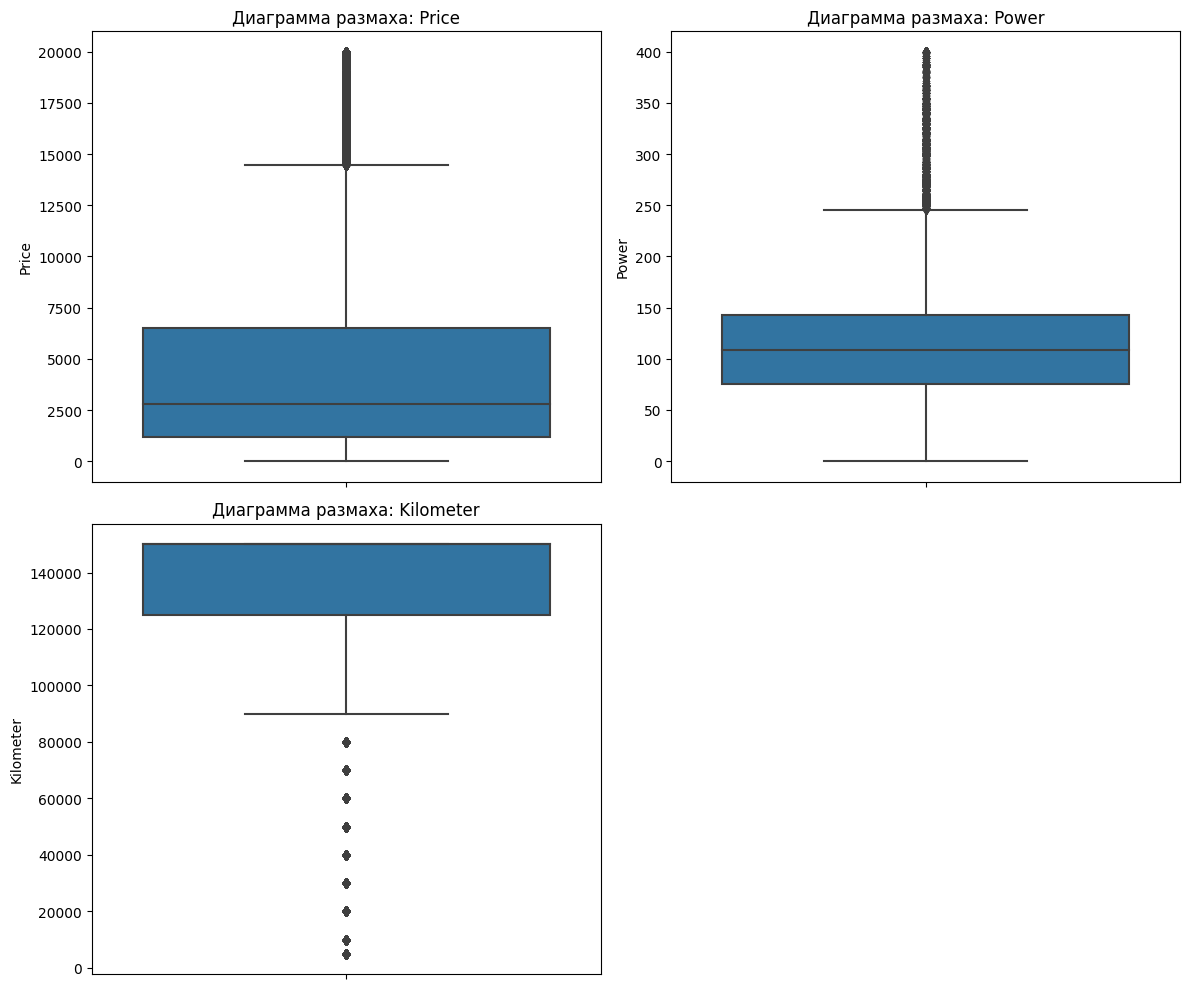

In [29]:
# Создаем визуализатор
viz_auto = Visualizer(df_auto_filtered)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_auto.boxplot(y=['Price', 'Power', 'Kilometer'])

Выбросы по признакам в пределах разумного, оставим их

### Диаграммы распределения

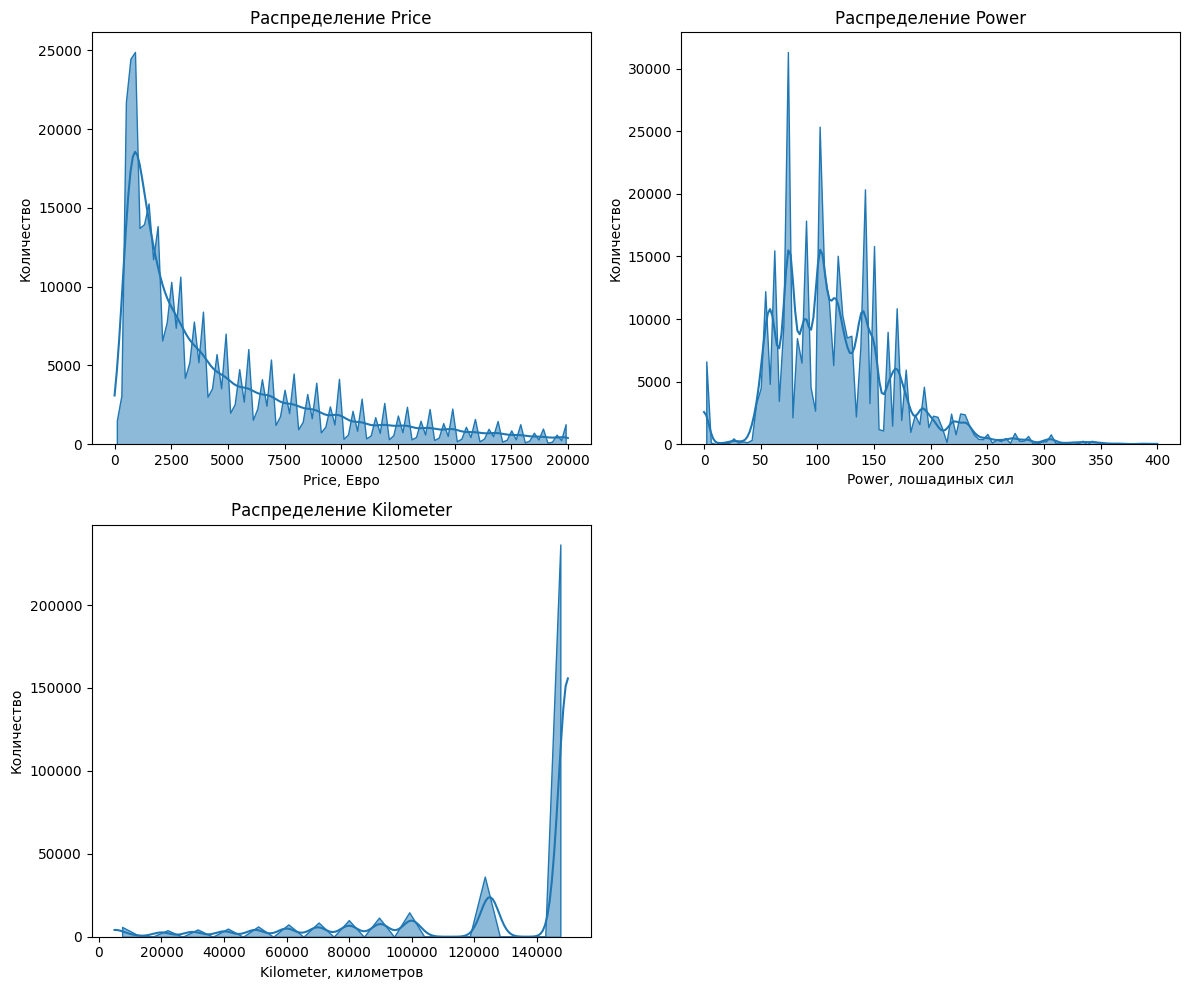

In [30]:
# Строим график распределения
viz_auto.histplot(x=['Price', 'Power', 'Kilometer'], 
                  measurement=['Евро', 'лошадиных сил', 'километров'])

Проверка на нормальность распределения

In [31]:
# Создаем список столбцов для проведения теста
df_auto_columns = ['Price', 'Power', 'Kilometer']

# Проверим распределение на нормальность с помощью теста
for column in df_auto_columns:
    stat, p = normaltest(df_auto_filtered[column])
    if p < 0.05:
        print(f"Признак {column} не имеет нормального распределения")
    else:
        print(f"Признак {column} имеет нормальное распределение")
    print('*' * 5)

Признак Price не имеет нормального распределения
*****
Признак Power не имеет нормального распределения
*****
Признак Kilometer не имеет нормального распределения
*****


#### Комментарии к диаграммам распределения

* Распределения признаков `Price`, `Power`, `Kilometer` унимодальные
* Распределение признака `Kilometer` имеет дискретный характер
* Признаки не имеют нормального распределения

### Диаграммы частот

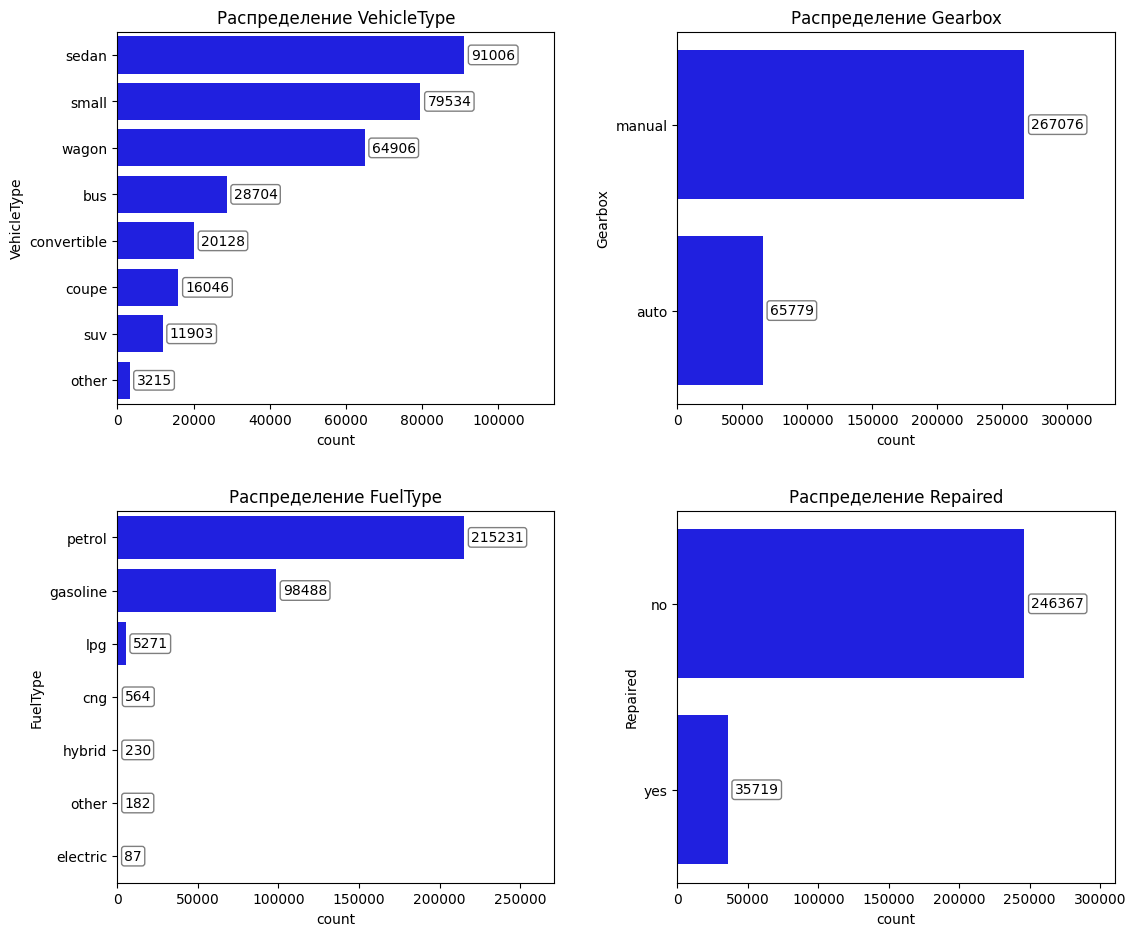

In [32]:
# Строим диаграммы частот
viz_auto.barplot(x=['VehicleType', 'Gearbox', 'FuelType', 'Repaired'])

#### Комментарии к диаграммам частот

Датасет в основном представлен следующими категориями:
* по типу кузова: седан, хэтчбек, универсал
* по типу коробки передач: авто с механикой в 4 раза больше, чем с автоматической КП
* по виду топлива: преимущественно бензиновые и дизельные
* по маркеру ремонта: большая часть авто не была в ремонте

### Диаграммы рассеяния

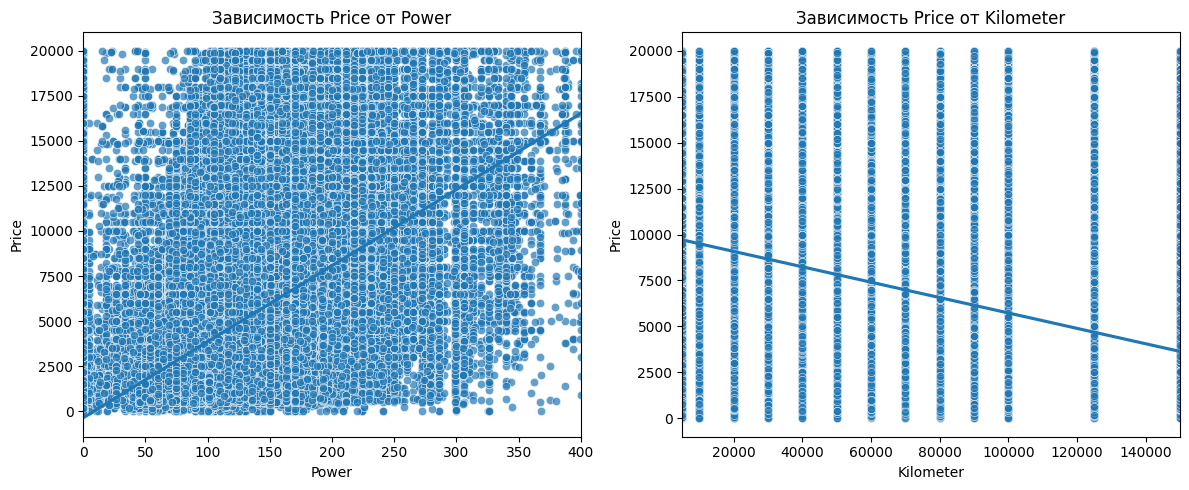

In [33]:
# Строим диаграмму рассеяния
viz_auto.scatterplot(x=['Power', 'Kilometer'], y='Price')

#### Комментарии к диаграммам рассеяния

* Корреляция цены и мощности имеет положительный характер
* Корреляция цены и пробега имеет отрицательный характер
* Характер зависимостей цены от признаков логически обосновано

### Корреляционный анализ

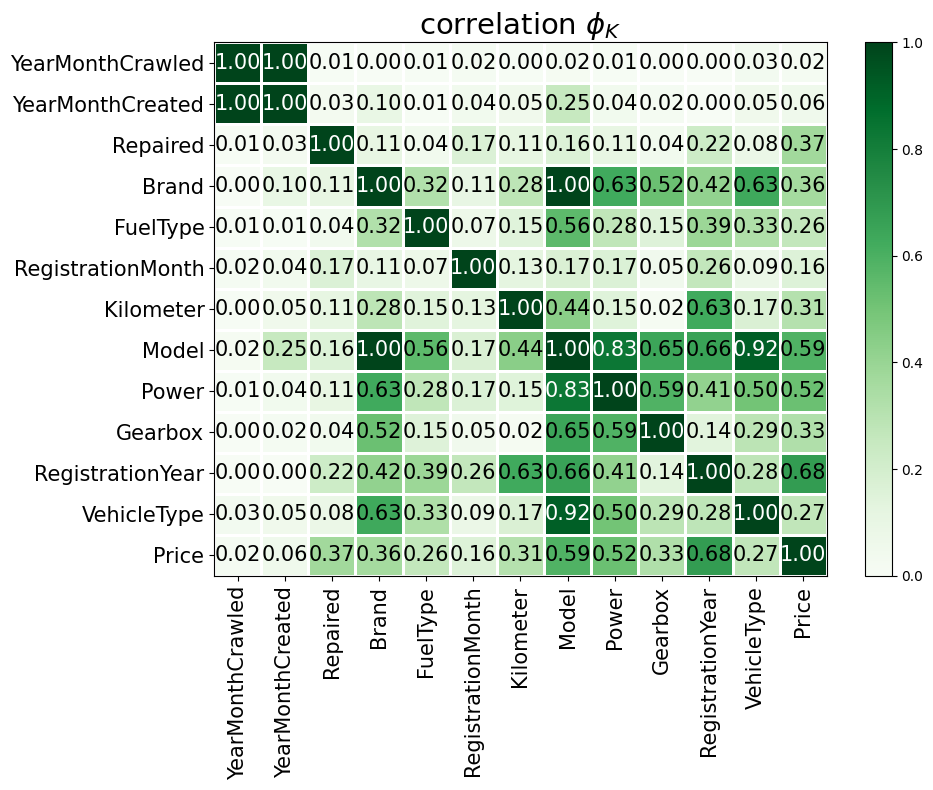

In [34]:
# Создаём список с наименованиями непрерывных признаков
interval_cols = ['Price', 'Power', 'Kilometer']

# Считаем корреляции на выборке
phik_overview_region_first = phik_matrix(df_auto_filtered.drop(['DateCrawled', 'LastSeen', 'PostalCode', \
                                                                'NumberOfPictures', 'Power_missing_flag', \
                                                                'DateCreated'], axis=1), \
                                         interval_cols=interval_cols)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview_region_first.values,
    x_labels=phik_overview_region_first.columns,
    y_labels=phik_overview_region_first.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
)

#### Комментарии к корреляционному анализу

* Обнаружена мультиколлениарность между признаками `Brand` и `Model`, что логично
* Важность признаков для цены распределилась следующим образом:
    * 0.69 Год регистрации
    * 0.57 Модель
    * 0.51 Мощность
    * Остальные признакие имеют коэффициент корреляции меньше 0.4

## Обучение моделей

### Особенности данных

**Категориальные признаки**

**OneHotEncoder (6 признаков)**

Используется, потому что признаки **номинальные** — между категориями **нет естественного порядка**. После кодирования модель сможет корректно работать с этими переменными, не искажая смысл категорий:

* `VehicleType` — тип кузова автомобиля *(имеются пропущенные значения)*
* `FuelType` — тип топлива *(имеются пропущенные значения)*
* `Gearbox` — тип коробки передач *(имеются пропущенные значения)*
* `Model` — модель автомобиля
* `Repaired` — состояние (был ли автомобиль в ремонте) *(имеются пропущенные значения)*

Используется как бинарный признак:
* `Power_missing_flag` - флаг об отсутствии данных по мощности в исходном датасете

---

**Количественные признаки (3 признаков)**

*Масштабирование* (например, `StandardScaler` или `MinMaxScaler`) рекомендуется для следующих признаков:

* `Power` — мощность двигателя
* `Kilometer` — пробег
* `RegistrationYear` — год регистрации

---

**Следующие признаки не войдут в модель (7 признаков)**

* Для прогноза цены автомобиля даты (`RegistrationMonth`, `DateCrawled`, `YearMonthCrawled`, `DateCreated`, `YearMonthCreated`, `LastSeen`) не дают информативного вклада — все объявления собраны в узком временном окне, и признаки отражают не характеристики машины, а процесс публикации
* Значения признака `NumberOfPictures` заполнены нулём по всем наблюдениям
* Признак `PostalCode`, на мой взгляд, не определяет стоимость автомобиля

### Повторная проверка на явные дубликаты

In [35]:
# Избавляемся от неинформативных признаков
df_auto_model = df_auto_filtered.drop(['DateCrawled', 'YearMonthCrawled', 'DateCreated', 'YearMonthCreated',\
                           'LastSeen', 'NumberOfPictures', 'RegistrationMonth', 'PostalCode'], axis=1)

# Проверка на наличие явных дубликатов
# Посчитаем их количество
df_auto_model.duplicated(keep='first').sum()

# Избавляемсся от явных дубликатов, оставляя первое вхождение
df_auto_model.drop_duplicates(keep='first', inplace=True)

# Проверка на наличие явных дубликатов
# Посчитаем их количество
df_auto_model.duplicated(keep='first').sum()

0

Датасет очищен от дубликатов перед построением модели

### Выбор метрики

* В качестве метрики качества модели выберем показатель RMSE (корень из среднеквадратичной ошибки)
* RMSE - это метрика, которая измеряется в единицах целевого признака, поэтому её легче интерпретировать, чем, например, MSE
* Лучшее значение RMSE стремится к нулю
* Порог успешного значения метрики RMSE задан на уровне меньше 2500

### Пайплайн модели

In [36]:
# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(
    df_auto_model.drop(['Price'], axis=1),
    df_auto_model['Price'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
ohe_columns = ['FuelType', 'VehicleType', 'Gearbox', 'Brand', 'Model', 'Repaired', 'Power_missing_flag']
num_columns = ['Power', 'Kilometer', 'RegistrationYear']

# ================== 3. Пайплайн обработки ==================

# OHE пайплайн
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
                    ]
                   )

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

# ================== 5. Сетка параметров ==================

param_grid = [

    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 3, 5, 7, 9, 11],
        'models__min_samples_leaf': [1, 2, 3, 4, 5],
        'models__max_features': [None, 1, 2, 3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели LightGBM()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],       # количество деревьев
        'models__learning_rate': [0.05, 0.1],  # шаг обучения
        'models__max_depth': [3, 5, 7, -1],      # глубина деревьев, -1 = без ограничения
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

# ================== 6. RandomizedSearchCV ==================

# Инициализируем класс для подбора гиперпараметров на 20 итераций
# значение кросс-валидации 3
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучаем модель
randomized_search.fit(X_train, y_train)

# ================== 7. Замер статистик по всем моделям ==================

cv_results = randomized_search.cv_results_
n_models = len(cv_results['params'])

results = []

for i in range(n_models):
    # Параметры текущей модели
    params = cv_results['params'][i]
    
    # Создаем копию пайплайна и применяем параметры
    model = clone(randomized_search.estimator)
    model.set_params(**params)
    
    # Замер времени обучения
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    
    # Замер времени предсказания на тесте
    t1 = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - t1
    
    # Кросс-валидация на тренировочном наборе
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(model, X_train, y_train,
                                cv=cv,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1)
    mean_rmse = np.abs(cv_scores.mean())
    
    # Сохраняем результат
    results.append({
        'model': type(model.named_steps['models']).__name__,
        'params': params,
        'train_time_sec': train_time,
        'predict_time_sec': predict_time,
        'cv_rmse': mean_rmse
    })

# Преобразуем в DataFrame и сортируем по RMSE
results_df = pd.DataFrame(results).sort_values('cv_rmse').reset_index(drop=True)
display(results_df)

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla

,model,params,train_time_sec,predict_time_sec,cv_rmse
0,LGBMRegressor,"{'preprocessor__num': 'passthrough', 'models__n_estimators': 200, 'models__max_depth': 5, 'models__learning_rate': 0.1, 'models': LGBMRegressor(learning_rate=0.05, max_depth=7, random_state=42)}",2.02,0.49,1792.98
1,LGBMRegressor,"{'preprocessor__num': RobustScaler(), 'models__n_estimators': 100, 'models__max_depth': 7, 'models__learning_rate': 0.05, 'models': LGBMRegressor(learning_rate=0.05, max_depth=7, random_state=42)}",2.59,0.46,1869.25
2,DecisionTreeRegressor,"{'preprocessor__num': RobustScaler(), 'models__min_samples_leaf': 3, 'models__max_features': 5, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",2.34,0.40,3300.11
3,DecisionTreeRegressor,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 2, 'models__max_features': 3, 'models__max_depth': 9, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",1.43,0.39,4404.42
4,DecisionTreeRegressor,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 1, 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",1.49,0.39,4422.82
5,DecisionTreeRegressor,"{'preprocessor__num': RobustScaler(), 'models__min_samples_leaf': 2, 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",1.41,0.39,4422.84
6,DecisionTreeRegressor,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 4, 'models__max_features': 3, 'models__max_depth': 9, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",1.47,0.38,4428.43
7,DecisionTreeRegressor,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 1, 'models__max_features': 3, 'models__max_depth': 7, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",1.40,0.39,4470.11
8,DecisionTreeRegressor,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 5, 'models__max_features': 1, 'models__max_depth': 9, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",1.36,0.38,4497.66
9,DecisionTreeRegressor,"{'preprocessor__num': 'passthrough', 'models__min_samples_leaf': 2, 'models__max_features': 1, 'models__max_depth': 5, 'models': DecisionTreeRegressor(max_features=5, min_samples_leaf=3, random_state=42)}",1.32,0.38,4523.91


* Опираясь на планку метрики в 2500, по ней проходит 2 модели LGBMRegressor.
* Далее из этих 2-х моделей выберем лучшую по скорости обучения и предсказания: это вторая модель LGBMRegressor с следующими показателями:
    * RMSE 1869
    * Время обучения 1.82 сек
    * Время предсказания 0.42 сек

### Предсказание лучшей модели

In [37]:
# ================== 8. Оценка на тестовой выборке ==================

# Берём параметры модели из таблицы
best_model_params = results_df.loc[1, 'params']

# Создаём копию пайплайна (тот же шаблон, что использовался для RandomizedSearchCV)
model_pipeline = clone(pipe_final)  # pipe_final — твой исходный пайплайн

# Устанавливаем параметры «бизнес-лучшей» модели
model_pipeline.set_params(**best_model_params)

# Обучаем на всей тренировочной выборке
model_pipeline.fit(X_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = model_pipeline.predict(X_test)

# Считаем RMSE на тесте
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE лучшей модели на тестовой выборке: {rmse_test:.0f}')

RMSE лучшей модели на тестовой выборке: 1867


### Анализ остатков лучшей модели

Среднее остатка: -5
Стандартное отклонение остатков: 1867
Минимум: -16901
Максимум: 18340


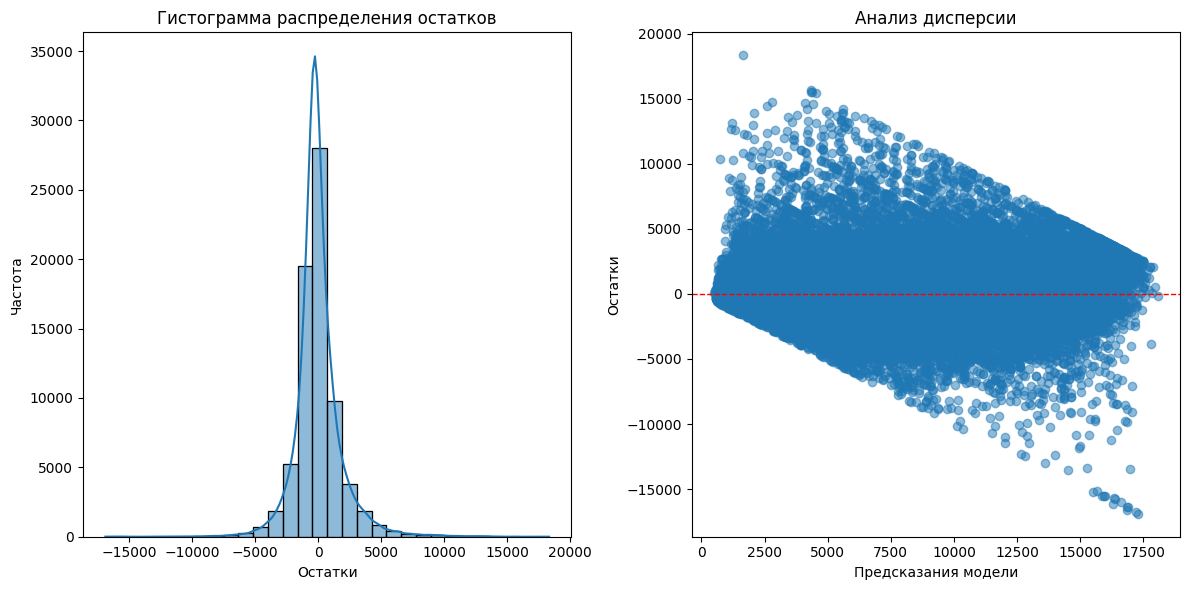

In [38]:
# 1. Рассчитаем остатки
residuals = y_test.values - y_pred

# 2. Статистики остатков
print("Среднее остатка:", round(np.mean(residuals)))
print("Стандартное отклонение остатков:", round(np.std(residuals)))
print("Минимум:", round(np.min(residuals)))
print("Максимум:", round(np.max(residuals)))

# 3. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Гистограмма распределения остатков
sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частота')

# Диаграмма рассеяния остатков против предсказаний
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

plt.tight_layout()
plt.show()


### Промежуточные выводы

* Модель с лучшей метрикой RMSE это LGBMRegressor, время обучения 1.79 сек, время предсказания 0.41 сек
* Метрика RMSE на тестовой выборке: 1867, что лучше уровня, заданного бизнесом
* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, значения распределены по характерному паттерну, что может свидительствовать о нестабильности модели

## Общий вывод

**Итоги этапа первичного анализа датасета**

* В работу поступил датасет с следующими основными характеристиками

* **Количество строк:** 354 369  

* **Пропущенные значения:** присутствуют в следующих столбцах:  
  - *VehicleType* 
  - *Gearbox*
  - *Model*
  - *FuelType*
  - *Repaired*

* **Необходимые преобразования:**  
  - Преобразовать даты (*DateCrawled*, *DateCreated*, *LastSeen*) в формат `datetime` для корректной работы с временными данными (например, сортировка, фильтрация, извлечение даты и времени).  
  - Проверить диапазон значений в числовых признаках (*Price*, *RegistrationYear*, *Power*) — возможны некорректные или экстремальные значения.  
  - Обработать пропуски в категориальных признаках — заменить на наиболее частое значение, категорию `"unknown"` или удалить строки при необходимости.  


* **Типы данных:**  
  - **Числовые:** *Price*, *RegistrationYear*, *Power*, *Kilometer*, *RegistrationMonth*, *NumberOfPictures*, *PostalCode* — корректно заданы как `int64`.  
  - **Временные:** *DateCrawled*, *DateCreated*, *LastSeen* — имеют тип `object`, необходимо привести к типу `datetime64[ns]` для удобства анализа по датам (например, изучения динамики размещения объявлений или активности пользователей).  
  - **Категориальные:** *VehicleType*, *Gearbox*, *Model*, *FuelType*, *Brand*, *Repaired* — представлены как `object`, рекомендуется преобразовать их в категориальный тип `category` для оптимизации памяти и повышения скорости обработки данных.

---

**Итоги этапа подготовки данных**

* Типы данных в столбцах с временнЫми и категориальными данными приведены в соответствие
* Пропущенные значения в 6-ти категориальных столбцах заполнены заглушкой "unknown" на этапе построения пайплайна моделей
* Удалено 8 явных дубликатов
* Неявные дубликаты не обнаружены

---

**Итоги этапа исследовательского анализа данных**

* Из исследования исключены аномально низкие значения (нули) по признаку `Price` ввиду невозможности достоверного заполнения и малой долей в датасете 3% от выборки
* Преобразованы аномально низкие и аномально высокие значения по признаку `Power`:
    * Здесь значения свыше 1000 л.с. и 10000 л.с. разделены соответственно на 10 и 100 для достижения адекватных значений мощности
    * Значения свыше 400 л.с., за исключением Porsche, приведены в соответствие медианному значению мощности по аналогу брэнда и модели 
* Построены диаграммы распределения по признакам:
    * Распределения признаков `Price`, `Power`, `Kilometer` унимодальные
    * Распределение признака `Kilometer` имеет дискретный характер
    * Признаки не имеют нормального распределения
* Построены диаграммы частот по признакам. Датасет в основном представлен следующими категориями:
    * по типу кузова: седан, хэтчбек, универсал
    * по типу коробки передач: авто с механикой в 4 раза больше, чем с автоматической КП
    * по виду топлива: преимущественно бензиновые и дизельные
    * по маркеру ремонта: большая часть авто не была в ремонте
* Построены диаграммы рассения по признакам `Price`, `Power`, `Kilometer`:
    * Корреляция цены и мощности имеет положительный характер
    * Корреляция цены и пробега имеет отрицательный характер
    * Характер зависимостей цены от признаков поддается логическому объяснению:
        * чем выше мощность, тем дороже автомобиль
        * чем выше пробег, тем дешевле автомобиль
* Проведен корреляционный анализ признаков:
    * Обнаружена мультиколлениарность между признаками `Brand` и `Model`, что логично
    * Важность признаков для цены распределилась следующим образом:
        * 0.69 Год регистрации
        * 0.57 Модель
        * 0.51 Мощность
        * Остальные признаки имеют коэффициент корреляции меньше 0.4

---

**Итоги обучения моделей**

**Постановка задачи**

* В качестве метрики качества модели выберем показатель RMSE (корень из среднеквадратичной ошибки). Лучшее значение RMSE стремится к нулю
* Порог успешного значения метрики RMSE задан на уровне меньше 2500

**Отбор признаков для моделей**

*Следующие признаки не вошли в модель (8 признаков)*
* Для прогноза цены автомобиля даты (`RegistrationMonth`, `DateCrawled`, `YearMonthCrawled`, `DateCreated`, `YearMonthCreated`, `LastSeen`) не дают информативного вклада — все объявления собраны в узком временном окне, и признаки отражают не характеристики машины, а процесс публикации
* Значения признака `NumberOfPictures` заполнены нулём по всем наблюдениям
* Признак `PostalCode`, на мой взгляд, также не определяет стоимость автомобиля
* После отбора признаков проведена проверка на явные дубликаты с их удалением

**Обучение моделей**

* Построены модели DecisionTreeRegressor и LGBMRegressor
* Модель, удовлетворяющая трем критериям бизнеса по качеству предсказания менее 2500, скорости обучения и предсказания это LGBMRegressor с следующими статистиками:
    * Метрика RMSE на тестовой выборке: 1867, что лучше уровня, заданного бизнесом
    * Время обучения 1.79 сек
    * Время предсказания 0.41 сек
* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков НЕравномерная, значения распределены по характерному паттерну, что может свидительствовать о нестабильности модели